# Bike Trips Dataset Exploration
## by Rubén Triviño

## Preliminary Wrangling

We will use a dataset from BayWheels of bike trips. Will explore possible relationships between trips duration, day of the week, hour of the day and number of rides.

We will download dataset of single month csv files and merge them into a single year dataset so we may perform further analysis.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

%matplotlib inline

In [ ]:
# Join all month .csv files into a single file to operate easily
# This process requires to download every month dataset from URL and put .csv files within project's root folder.
# Otherwise skip this step
trip_data = pd.DataFrame();
for year in np.arange(19,20):
    for month in np.arange(1,13):
        monthNumber = "";
        if month < 10:
            monthNumber = "0{}".format(month);
        else:
            monthNumber = str(month);
        monthdf = pd.read_csv("dataset/20{year}{month}-fordgobike-tripdata.csv".format(year=year, month=monthNumber));
        trip_data = trip_data.append(monthdf)
    trip_data.to_csv("trip_data-{}.csv".format(year), index=False)

### Load Dataset

In [28]:
trip_data = pd.read_csv("trip_data-19.csv", low_memory=False)

In [3]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
 13  bike_share_for_all_trip  object 
 14  rental_access_method     object 
dtypes: float64(6), int64(2), object(7)
memory usage: 286.9+ MB


First we will transform columns type related to Dates into datetimes types so we can operate with these conviniently.

In [4]:
trip_data["start_time"] = pd.to_datetime(trip_data["start_time"])
trip_data["end_time"] = pd.to_datetime(trip_data["end_time"])
trip_data["start_time_day_of_week"] = trip_data["start_time"].dt.dayofweek
trip_data["start_time_day"] = trip_data["start_time"].dt.day
trip_data["start_time_hour"] = trip_data["start_time"].dt.hour

### What is the structure of your dataset?

The data structures includes anonimous bike rides containing the next information per ride:
* Trip duration (seconds).
* Start datetime.
* Finish datetime.
* Station ID where the ride starts from.
* Station name where the ride starts from.
* Latitude of the station where the ride starts from.
* Longitude of the station where the ride starts from.
* Station ID where the ride ends.
* Station name where the ride ends.
* Latitude of the station where the ride ends.
* Longitude of the station where the ride ends.
* Bike ID
* User type (Subscriber or Customer)

### What is/are the main feature(s) of interest in your dataset?

All of the date is of high interest: start date may help us understand if certain day of the week has more higher usage ratio of the bikes or even it may shows a relation between trips duration. In addition, the identification of the main bike stations may show a problem related to the availability of bikes due to the fact that many people start the raid in a station but they drop the bike in a very different one so the company need to replenish the station every certain period of time. Also, ID of bike may help us the how often the same bake is used during his lifetime so we may identify the potencial value that a single bike may generate over its costs. Furthermore, the type of user and how it enganges to the bike usage overtime may help us understand what type of user we are interested in and what type we should look forward to get more of them, what time it requires to convert a casual consumer into a subscriber.

From all these ideas the key feature is Time.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

For the porpuse of this study we will be keen on the start datetime of the ride and its duration. Which day of the week has the most number of rides? Is there certain hour of the day that has a spike on rentals? May it be related to the duration of the ride? Is theree any difference in bike usage between user types?
Then, in order to answer these questions we will use these main features of the dataset:
* Start Time (hour of the day, day of the week)
* Duration
* User Type

## Univariate Exploration

### What hour of the day has more starting rides?

In [5]:
color_palette = sb.color_palette()[0]

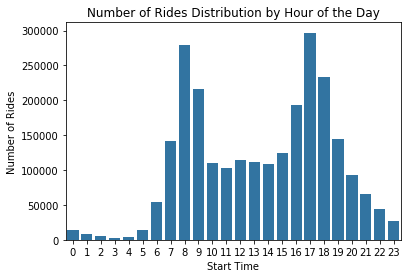

In [6]:
sb.countplot(data=trip_data, x="start_time_hour", color=color_palette);
plt.title("Number of Rides Distribution by Hour of the Day");
plt.ylabel("Number of Rides");
plt.xlabel("Start Time");

We can observe a bimodal distribution on the number of rides started by hour of the day. The two pikes that we find may be related to the hours of going to work or getting off it.

### Is there any difference on bike usage depending on the day of the week?

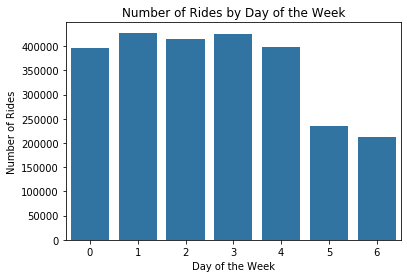

In [7]:
sb.countplot(data=trip_data, x="start_time_day_of_week", color=color_palette);
plt.title("Number of Rides by Day of the Week");
plt.ylabel("Number of Rides");
plt.xlabel("Day of the Week");

As we may see at the graph, it seems to be a consistently difference on the number of rides if they day is a weekday or it is from weekend. However, the days within the same group present similar number of rides. This relationship may have an impact on other features too so we will engineer a feature where we will say if it is weekday or weekend day.

### How is user type distribution relative to the bike usage?

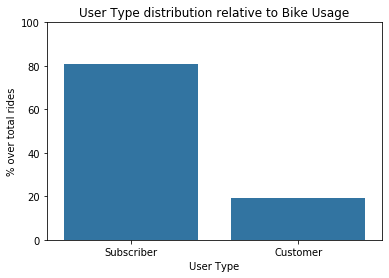

In [8]:
user_types = ["Subscriber", "Customer"]
total_trips = trip_data["user_type"].value_counts()/trip_data.shape[0] * 100
total_trips = total_trips.reset_index();
total_trips.rename(columns={"user_type": "distribution", "index": "user_type"}, inplace=True)
sb.barplot(data = total_trips, x="user_type", y="distribution", color=color_palette, order=user_types);
plt.title("User Type distribution relative to Bike Usage");
plt.ylabel("% over total rides");
plt.xlabel("User Type");
plt.ylim(0,100);

Since we do not have unique identifiers for users we cannot know user type distribution. However, we are able to see user type distribution relative to the number of rides that each one takes.
Therefore, we may see that the number of rides are from Subscriber users mainly. However, we do not know how is the duration of the rides regarding to the user type. So, what type of user would we like the most in terms of ride duration (potentially more money from renting the bike)? Do they have different usage profiles?

In [9]:
def weekdayType(row):
    dayType = "Weekend";
    if row["start_time_day_of_week"] < 5:
        dayType = "Weekday";
    return dayType
trip_data["day_type"] = trip_data.apply(weekdayType, axis=1)

### What is the average trip duration?

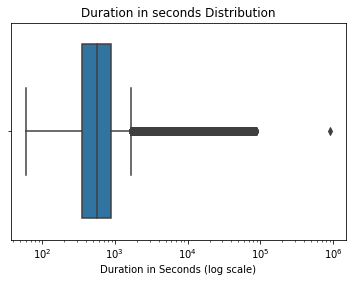

In [10]:
sb.boxplot(x=trip_data["duration_sec"]);
plt.xscale("log")
plt.xlabel("Duration in Seconds (log scale)");
plt.title("Duration in seconds Distribution");

Despite the spread of the distribution it seems to be an outlier in the dataset.

In [11]:
trip_data[trip_data["duration_sec"]>100000]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method,start_time_day_of_week,start_time_day,start_time_hour,day_type
2481276,912110,2019-12-19 23:15:36,2019-12-30 12:37:26,NaN,NaN,37.323757,-121.878614,NaN,NaN,37.327656,-121.868598,614329,Customer,NaN,app,3,19,23,Weekday


We will remove it as it does not have all features filled and the value of duration seems to be wrong.

In [12]:
trip_data.drop(2481276, inplace=True);

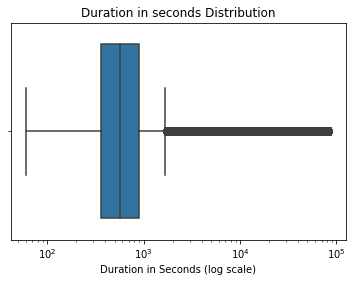

In [13]:
sb.boxplot(x=trip_data["duration_sec"]);
plt.xscale("log");
plt.xlabel("Duration in Seconds (log scale)");
plt.title("Duration in seconds Distribution");

Even though it seems to be a big amout of outliers we may not consider them like that due to the fact that may be a reason behind such us: company bike rents, riders delivering food, or other kind that may explain such a long rides. However, it is true that they not represent the majority.

In [14]:
np.percentile(trip_data["duration_sec"],95)

1760.0

So the 95% of the rides durations are below 1760 seconds.

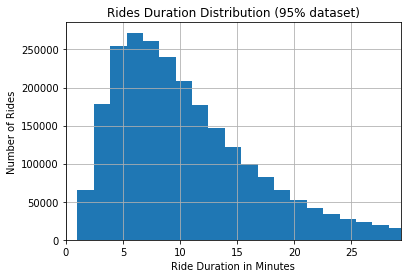

In [15]:
trip_data["duration_min"] = trip_data["duration_sec"]/60 
trip_data["duration_min"].hist(bins=1000);
plt.xlim(0, 1760/60);
plt.title("Rides Duration Distribution (95% dataset)");
plt.ylabel("Number of Rides");
plt.xlabel("Ride Duration in Minutes");

As we have identified, more than 95% of the rides' duration are below 30 minutes (1760 seconds). However, there are a consistent amount of rides that are far above of that duration a long tail. This may be relevant in terms of the overall rented bikes duration. So we may identify what type of users are those.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

As we have seen, bike usage distribution seems to be bimodal during weekdays. However, we also noticed that there is a sustancial difference between weekdays and weekends that will require further exploration.

On the other hand, user type distribution shows that Subscribers are more abundant than Customers (casual customers). However, we will see if that different persists in terms of total trip duration.

Regarding to trips duration, we noticed that there is a small portion of rides that its duration is much larger than the average. As we said, even though this is not representative we cannot consider it as outliers. We will have to explore what is the impact on other features of this longtail of long duration trip riders.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

As part of the data wrangling process we converted columns holding datetime values as DateTime type instead of their original type: string.
Also, we discard an outlier identified by the trip duration that clearly seems to be an error in the dataset.

## Bivariate Exploration
In this section we will explore the relationship between features such as: is there any difference between user types on the time when they start the trips? Is the difference between user types relevant in terms of trip duration? How is the bike starting hour shape different from weekdays to weekend? Is the average trip duration similar from weekdays to weekend?

### Bike usage by User Type

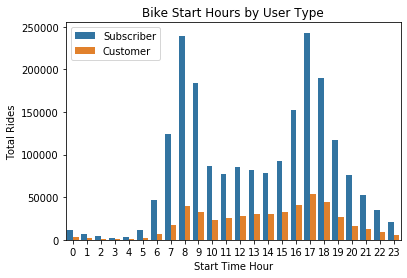

In [16]:
sb.countplot(data=trip_data, x="start_time_hour", hue="user_type");
plt.legend(user_types);
plt.title("Bike Start Hours by User Type");
plt.ylabel("Total Rides");
plt.xlabel("Start Time Hour");

Even though both users present similar shapes Customer Type seems to have a bimodal distribution flatter.

### What is the user type share relative to total trip duration?

In [17]:
total_trip_duration = trip_data["duration_sec"].sum()
trip_duration_by_user_type = trip_data.groupby(by="user_type").sum()["duration_sec"]/total_trip_duration * 100;
trip_duration_by_user_type = trip_duration_by_user_type.reset_index();

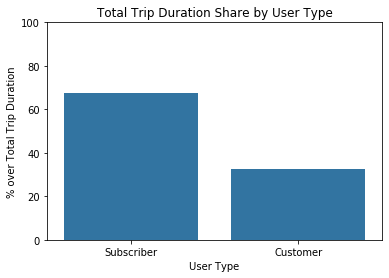

In [18]:
sb.barplot(data = trip_duration_by_user_type, x="user_type", y="duration_sec", order=user_types, color=color_palette);
plt.title("Total Trip Duration Share by User Type");
plt.ylabel("% over Total Trip Duration");
plt.xlabel("User Type");
plt.ylim(0,100);

In terms of trip duration, the difference between Subscribers and Customers is consinstently smaller. So, even though Customers make less trips they have a bigger impact on trips duration and should be taken into account in any user evaluation.

### What are the rides duration by hour of the day?

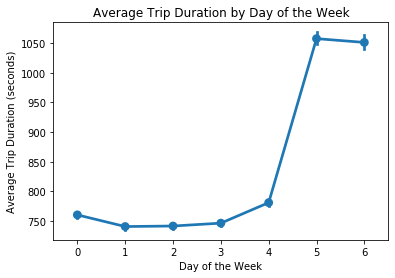

In [19]:
sb.pointplot(data=trip_data, x="start_time_day_of_week", y="duration_sec", color=color_palette);
plt.title("Average Trip Duration by Day of the Week");
plt.ylabel("Average Trip Duration (seconds)");
plt.xlabel("Day of the Week");

If we analyze the average trip duration on every day of the week we found again a great difference between weekdays and weekends. In specifics, we find an increase of 20% on trip durations on weekends than those from weekdays while those trips within the same group present similar results.

### At what time do start longest trips?

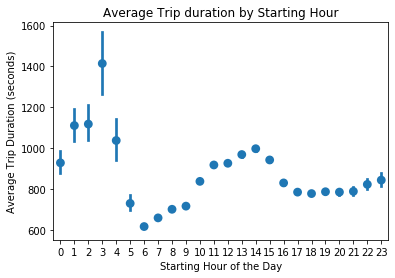

In [20]:
sb.pointplot(data=trip_data, x="start_time_hour", y="duration_sec", join=False, color=color_palette);
plt.title("Average Trip duration by Starting Hour");
plt.ylabel("Average Trip Duration (seconds)");
plt.xlabel("Starting Hour of the Day");

Trips duration has an inverted shape to the starting hour of trips as it present the lowest values during the pikes we find in previous charts. Those hours where we get the highst volumen of bike rides is when the rides are shorter.

## How is the bike usage during weekdays and weekends?

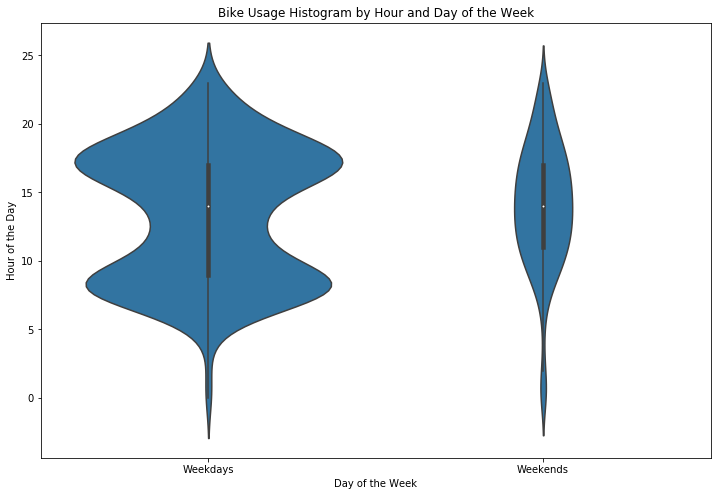

In [21]:
plt.figure(figsize=(12,8));
sb.violinplot(data=trip_data, y="start_time_hour", x="day_type",bw=.3, scale="count", color=color_palette);
plt.title("Bike Usage Histogram by Hour and Day of the Week");
plt.ylabel("Hour of the Day");
plt.xlabel("Day of the Week");
plt.xticks([0, 1], ["Weekdays", "Weekends"]);

As we can see in the above graph, bike usage distribution along hours of the day and type of day of the week, it present a very different shape. While bike usage during weekdays shows a bimodal distribution, during weekends we observe a normal distribution if we neglect the starting hours of the day.

### About some relationhips observed

We observed that they shape of bike usage is strongly linked to the day of the week. While weekdays present a big difference from weekends, days within the same group present very similar distribution.

In the same way, trips duration seems to be related with day hour of the day such as the hour of most activity present the shortest trip durations.

In addition, even though user types present similar usage trends they different in quantity. Eventhough, the user type distribution of Subscribers is above 80% of users in relative to bike trips, it is not the case when we compare to absolute values of trip durations. In this case, Subscribers presents almost 65% of users due to the fact that Customer users have an average trip longer.

We also aboserved that the trip duration increases almost a 20% when trips is started on weekends.

## Multivariate Exploration

We have seen some relationships between trip starting time and trip duration, trip startin time and user type or user type and trip duration. But, what about start time by user type and day of the week or what about how these shapes varies from one station to another?

### Trip Duration by user Type and Day Hour

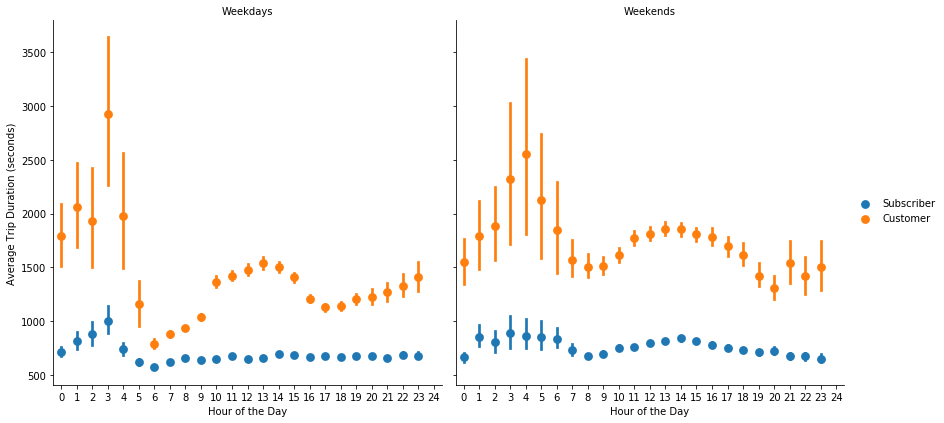

In [25]:
g = sb.FacetGrid(trip_data, col="day_type", height=6);
g.map(sb.pointplot, "start_time_hour", "duration_sec", "user_type", join=False, hue_order=user_types, order=np.arange(0,25,1), palette=sb.color_palette());
g.set_titles("{col_name}s");
g.set_ylabels("Average Trip Duration (seconds)");
g.set_xlabels("Hour of the Day");
g.add_legend();

As we pointed out before, Customers take longer trips in average contrary to what Subscribers do. Subscribers show an almost horizontal line with very small variations. It illustrate that Subscribers are users who knows their trip as they do very often while Customers present more variability and longer trips.

### Bike usage by day and user type

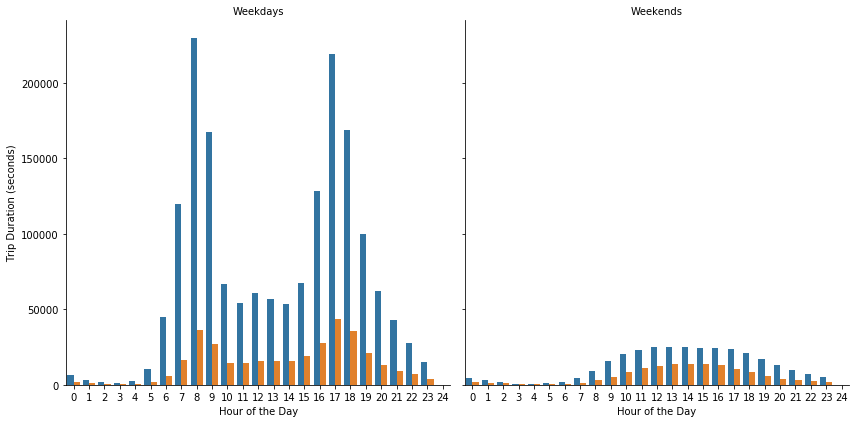

In [23]:
def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)

g = sb.FacetGrid(trip_data, col="day_type", height=6);
g.map(countplot, "start_time_hour", "user_type", hue_order=user_types, order=np.arange(0,25,1), palette=sb.color_palette());
g.set_titles("{col_name}s");
g.set_ylabels("Trip Duration (seconds)");
g.set_xlabels("Hour of the Day");

As we may observe, user type does not have an impact on the time of day the trips are taken off but on the volumen of bike trips.

### Bike usage shapes by day type and top ten stations by name


In [26]:
stations_order = trip_data["start_station_name"].value_counts()[:10].index;

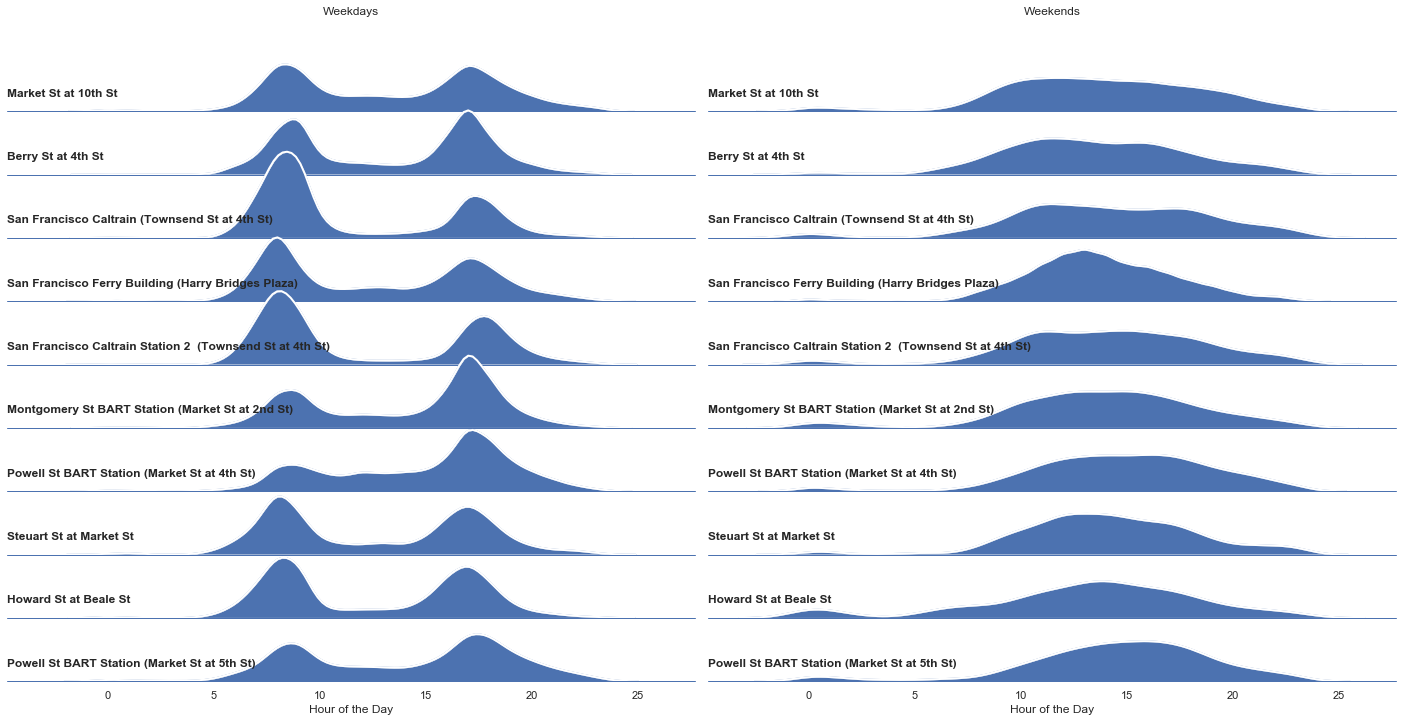

In [27]:
import math
sb.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)});
res = trip_data["start_time_hour"].values;
g = sb.FacetGrid(data = trip_data, row="start_station_name", col="day_type", row_order=stations_order, aspect=10, height=1);
g.map(sb.kdeplot, "start_time_hour", clip_on=False, shade=True, alpha=1, lw=1.5);
g.map(sb.kdeplot, "start_time_hour", clip_on=False, color="w", lw=2);
g.map(plt.axhline, y=0, lw=1, clip_on=False);


axes = g.axes.flatten()
index = 0;
for ax in axes:
    ax.text(0, .2, stations_order[math.floor(index/2)], fontweight="bold",
            ha="left", va="center", transform=ax.transAxes)
    if index==0:
        ax.set_title("Weekdays");
    elif index==1:
        ax.set_title("Weekends");
    else:
        ax.set_title("");
    index+=1

g.fig.subplots_adjust(hspace=-.30);


# Remove axes details that don't play well with overlap
g.set(yticks=[]);
g.despine(bottom=True, left=True);
g.set_xlabels("Hour of the Day");

Last graph shows that every station present similar shapes; bimodal on weekdays and normal on weekends. However, they also show particularities in size, distance between pikes, horizontal shifts or even little areas with residual trips. 

### About some relationhips observed
Surprisingly, the two types of user have similar shapes on the different days of the week. The only difference is the volume of trips that each type during the day. 

However, we have seen how Customer users make longer trips than Subscribers and have a higher variability, while Subscribers have a flat curve of the duration of their trips throughout the day.

By comparing the busiest stations, we have seen that they have very similar usage profiles. Between stations there are only small variations in volume, time differences or small isolated areas with residual bicycle use.
